<a href="https://colab.research.google.com/github/ikikika/data_science/blob/titanic-kaggle/titanic-kaggle/titanic_kaggle_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define Problem
Build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Import Dependencies

In [1]:
pip install catboost

     |████████████████████████████████| 64.8MB 66kB/s 


In [2]:
%matplotlib inline 
# Need to run this line to see the graphs

# Start python imports
import math, time, random, datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Ignore warnings for now
# import warnings
# warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the Data

In [3]:
import pandas as pd

train = pd.read_csv('https://raw.githubusercontent.com/ikikika/data_science/titanic-kaggle/titanic-kaggle/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/ikikika/data_science/titanic-kaggle/titanic-kaggle/test.csv')

### Find missing values

In [4]:
train.info()
# From here, we can see that 'Age', 'Cabin' and 'Embarked' has missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


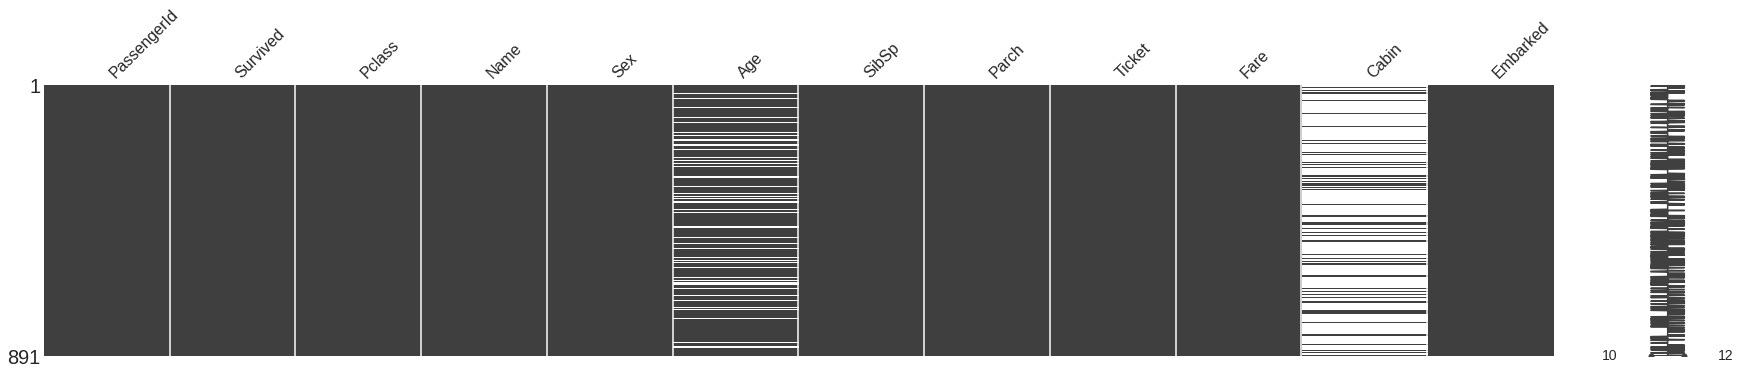

In [5]:
# Plot graphic of missing values
missingno.matrix(train, figsize=(30,5))

This is another way of visualising missing data.

This graph shows the position of the missing values, most of them are in the 'Age' and 'Cabin' columns.

In [6]:
# Function to show how many missing values there are
def find_missing_values(df, columns):
  '''
  Finds no of rows where certain columns are missing values
  :: param df :: = target dataframe
  :: param columns :: = list of columns
  '''
  missing_vals = {}
  print('Number of missing or NaN values for each column: ')
  df_length = len(df)
  for col in columns:
    total_column_values = df[col].value_counts().sum()
    missing_vals[col] = df_length - total_column_values
  return missing_vals

find_missing_values(train, columns=train.columns)

Number of missing or NaN values for each column: 


{'Age': 177,
 'Cabin': 687,
 'Embarked': 2,
 'Fare': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [7]:
# In the video, he wrote the above function to get how many null objects in each column. This function will get the same info.
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform data analysis, create 2 new dataframes
Create 1 for exploring discretised continuous variables (continuous variables which can be sorted into some kind of category).
* variables that cannot be defined using a sliding scale 
* variables that has to be categorised or divided into bins
* these variables can be assigned numerical values, but only those assigned values have meaning. eg, if we assign red=1 and blue=2, 1 and 2 
will have meaning but 1.5 will have no meaning. And also, 2 red (1+1) doesnt equal 1 blue (2).
* eg, color, gender, locations

Another for exploring continuous variables.
* sliding scale values
* if we have a scale from 0-100, continuous variables can take any value between 0-100, eg. 0.00001, 3.1415926535
* eg, fare, age

In [8]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

### Explore each feature individually

#### Target feature: Survived
Description:  whether the passenger survive or not

Key: 0=dead, 1=survive.

This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


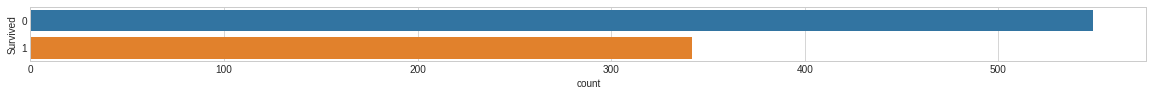

In [9]:
# How many people survived?
fig = plt.figure( figsize=(20,1) )
sns.countplot( y='Survived', data=train )
print( train.Survived.value_counts() )
# Tip: We see that more people didnt survive. If our prediction has more survivors, something is wrong.

In [10]:
# Add Survived to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

#### Feature: Pclass
Description:  Ticket class of passenger

Key: 1=1st, 2=2nd, 3=3rd

Look at the distribution of each feature to see if we can understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

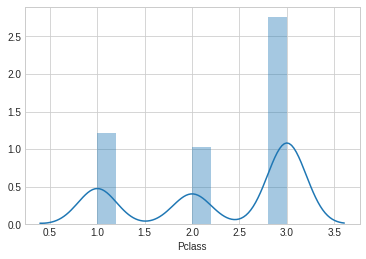

In [11]:
sns.distplot(train.Pclass)

In [12]:
# How many missing values does Pclass have?
# missing_vals['Pclass']
# or train['Pclass'].isnull().sum()

In [13]:
# Since there are no missing values in Pclass, add to our subset dataframes
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [14]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


#### Feature: Name
Description: Name of passenger

In [15]:
len(train['Name'])
# As each name in this dataset is unique, its not efficient for us to use this feature.
# Think: Can we reduce the number of names?
# Think: Can we correlate the name to survival rate? eg, people named jack are more likely to die than people named rose.
# Think: Can we create new feature out of the names? Yes. We can extract the titles (Mr, Mrs, Miss) and form them into another feature (as seen in the other video). We wont do that here.

891

#### Feature: Sex
Description: The gender of the passenger

male      577
female    314
Name: Sex, dtype: int64


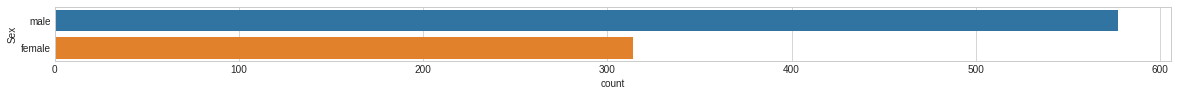

In [16]:
# View distribution of Sex
fig = plt.figure( figsize=(20,1) )
sns.countplot( y='Sex', data=train )
print( train.Sex.value_counts() )

In [17]:
# Missing values for Sex?
# missing_vals['Sex']

In [18]:
# No missing values, we can add them to our subset dataframe.

df_bin['Sex'] = train['Sex']

# Convert the labels to numerical values (male=0, female=1)
df_bin['Sex'] = np.where( df_bin['Sex'] == 'female', 1, 0 )

df_con['Sex'] = train['Sex']
df_con['Sex'] = np.where( df_con['Sex'] == 'female', 1, 0 )

In [19]:
df_con.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


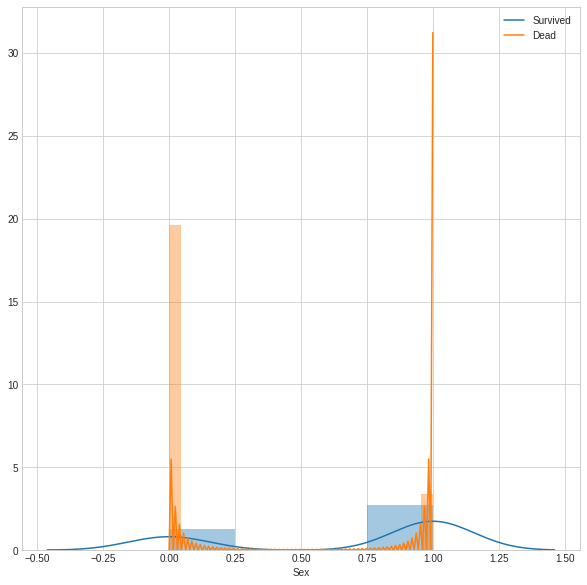

In [20]:
# Compare Sex with Survived
fig = plt.figure( figsize=(10,10) )
sns.distplot( df_bin.loc[ df_bin['Survived'] == 1 ]['Sex'], kde_kws={'label': 'Survived'} )
sns.distplot( df_bin.loc[ df_bin['Survived'] == 0 ]['Sex'], kde_kws={'label': 'Dead'} )

Not many people survived. But those who did, most of them are females.

#### Feature: Age
Description: Age of passenger

In [21]:
# Missing values for Age?
# missing_vals['Age']

# 177 missing values for age
# Think: How can we fill in the missing values?
# For this exercise, we wont use this feature. 
# We did fill in the missing values for the other video.

Function to create count and distribution visualisations

In [22]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20,5), use_bin_df=False):
  if use_bin_df:
    fig = plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    sns.countplot( y=target_column, data=bin_df )
    plt.subplot(1,2,2)
    sns.distplot( data.loc[ data[label_column] == 1 ][ target_column ], kde_kws={'label': 'Survived'} )
    sns.distplot( data.loc[ data[label_column] == 0 ][ target_column ], kde_kws={'label': 'Dead'} )
  else:
    fig = plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    sns.countplot( y=target_column, data=data )
    plt.subplot(1,2,2)
    sns.distplot( data.loc[ data[label_column] == 1 ][ target_column ], kde_kws={'label': 'Survived'} )
    sns.distplot( data.loc[ data[label_column] == 0 ][ target_column ], kde_kws={'label': 'Dead'} )

#### Feature: SibSp
Description: The number of siblings/spouses the passenger has on board.

In [23]:
# Missing values for SibSp?
# missing_vals['SibSp']
train['SibSp'].isnull().sum()

0

In [24]:
# Value coutns for SibSp
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [25]:
# Add SibSp to subset dataframe.
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

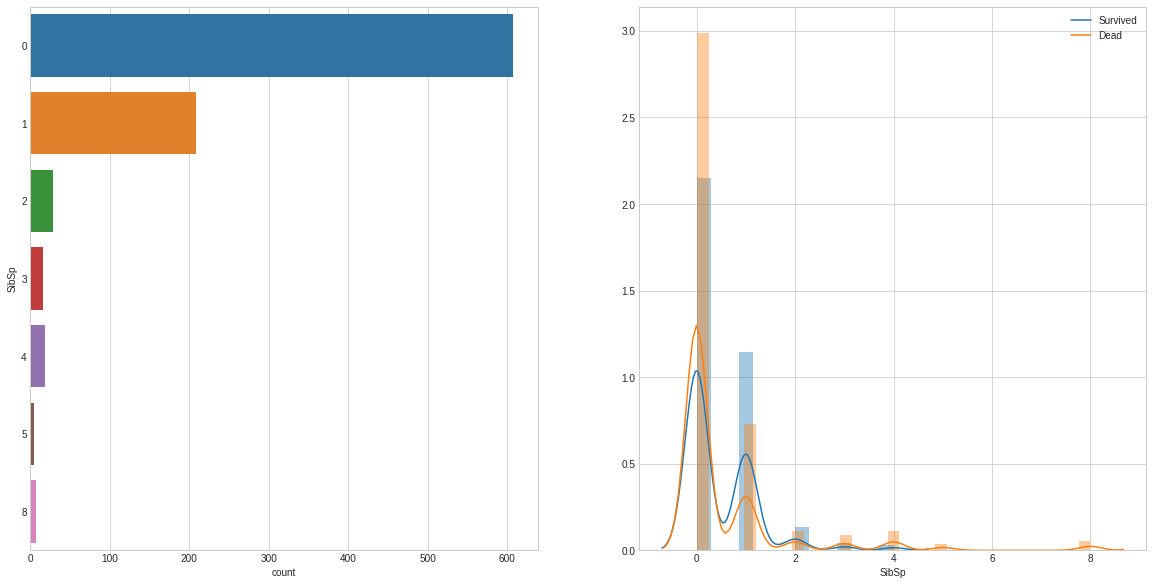

In [26]:
plot_count_dist(train, df_bin, 'Survived', 'SibSp', (20,10))

From the graph on the left, we can see that passengers with 0 siblings or spouses on board are more likely to die.

Passengers with 1 sibling or spouse on board are more likely to survive.

Almsot equal chances of surviving or dying for the rest.

#### Feature: Parch
Description: The number of parents/children the passenger has on board.

In [27]:
# Missing values?
train['Parch'].isnull().sum()

0

In [28]:
# Add SibSp to subset dataframe.
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

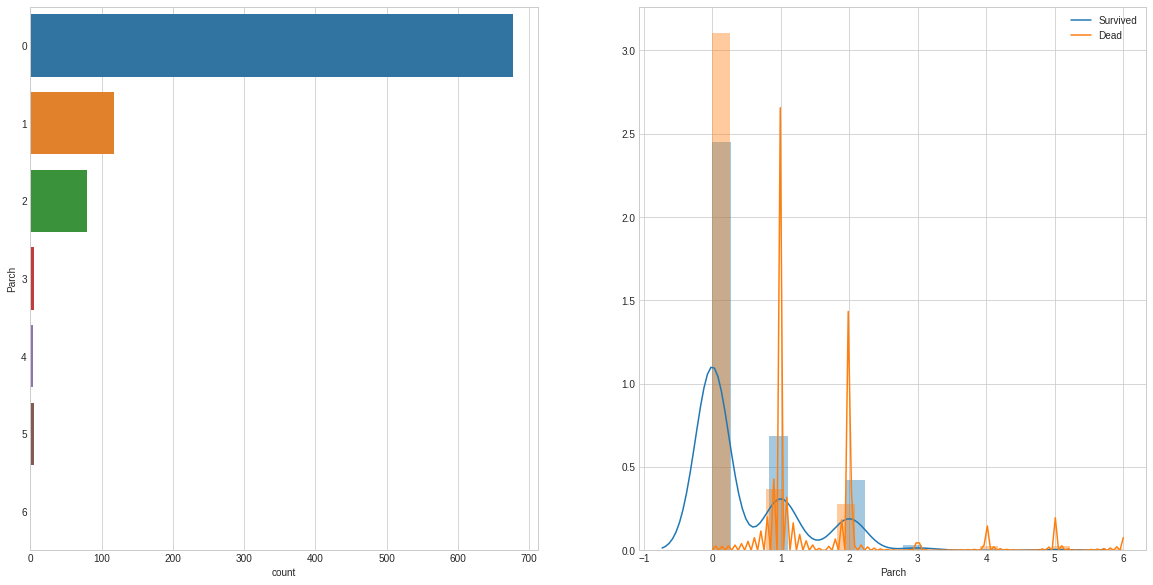

In [29]:
plot_count_dist(train, df_bin, 'Survived', 'Parch', (20,10))

Passengers with no parents/children on board are more likely to die.

Passengers with 1 or more parents/children on board are more likely to survive.

#### Feature: Ticket
Description: The ticket number of the passenger.

In [30]:
# Missing values?
train['Ticket'].isnull().sum()

0

In [31]:
train['Ticket'].value_counts()

1601           7
CA. 2343       7
347082         7
3101295        6
347088         6
              ..
SW/PP 751      1
W./C. 14258    1
28425          1
2626           1
345770         1
Name: Ticket, Length: 681, dtype: int64

681 unique ticket values.

Too many unique values, hence we wont use this feature in our model.

Think: Any way to reduce this number?

#### Feature: Fare
Description: How much the ticket cost?

In [32]:
# Missing values?
train['Fare'].isnull().sum()

0

In [33]:
# How many different values of Fare are there?
train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

Because Fare is a float (decimal number) and is a continuous variable, we can add to continuous sub dataframe.

To add to categorical sub dataframe, divide it into bins.

In [34]:
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) #discretised

In [35]:
df_bin.Fare.value_counts()
# 5 bins

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

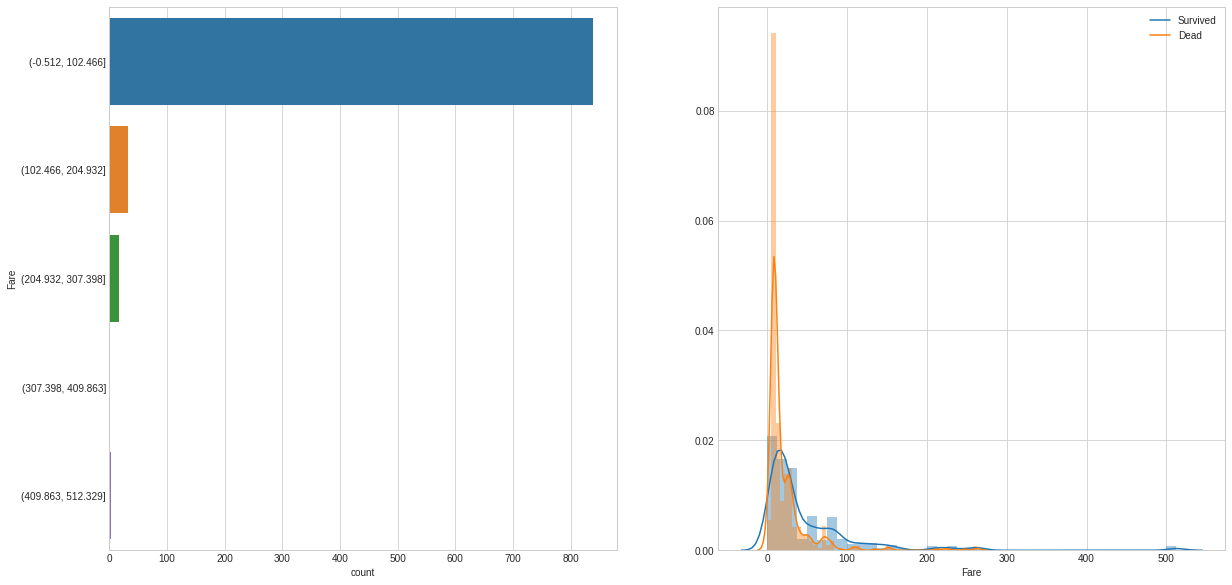

In [36]:
plot_count_dist(train, df_bin, 'Survived', 'Fare', (20,10), True)

Passengers who pay more are more likely to survive.

#### Feature: Cabin
Description: The cabin number where the passenger is staying

In [37]:
train['Cabin'].isnull().sum()

687

In [39]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
E101           3
              ..
A16            1
F38            1
B80            1
B39            1
D56            1
Name: Cabin, Length: 147, dtype: int64

Too many unique values and too many missing values for cabin.

Hence we wont use it.

#### Feature: Embarked
Description: The port where the passenger embarked

Key: C = Cherbourg, Q = Queenstoen, S = Southampton


In [40]:
# Missing values?
train['Embarked'].isnull().sum()

2

In [42]:
# What kind of values are in Embarked?
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a vategorical variable because there are 3 categories where a passenger could have boarded on

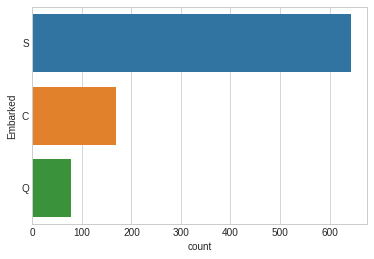

In [43]:
sns.countplot( y='Embarked', data=train)

**How can we deal with the 2 missing values of Embarked?**

One option is to remove the 2 rows.

Another option is to randomly assign a value of C, S or Q.

Think: pros and cons of each method?

Think: any other way to fill in the values?

For now, we will drop the 2 rows.

In [44]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [46]:
# Remove rows where Embarked is null
print( len(df_con) )
df_con = df_con.dropna( subset = ['Embarked'] )
df_bin = df_bin.dropna( subset = ['Embarked'] )
print( len(df_con) )

891
889
